# Expériences sur données réelles

In [17]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pandas as pd
import scipy
import csv

from datetime import datetime, timedelta

from src.poisson_process import NHPoissonProcess
from src.mcmc import PoissonMCMC
from src.visualisation import *
from parameters.params import Params
from src.densities import gpd_quantile
from src.rhat_infinity import *

import warnings
warnings.filterwarnings('ignore')

COLOR_LIST = ["xkcd:blue violet", "xkcd:shamrock", "xkcd:coral"]

## Débits du Rhône 

Voir section 4.2.1 de la thèse de Clément

**Seuil recommendé par EDF**: 2400


In [2]:
data_file = "data/Golfech_CRUE_1915-2013.txt"



def extract_data_castor(threshold):
    
    observations_under_u = []
    observations_above_u = []

    time_under_u = []
    time_over_u = []
    

    with open(data_file, "r", encoding="ISO-8859-1") as f:
        #skipping the first information lines
        for i in range(7):
            f.readline()

        current_line = f.readline().split()
        current_time = datetime.strptime(current_line[0][1:-1], '%d/%m/%Y')
        while current_line:
            current_time = datetime.strptime(current_line[0][1:-1], '%d/%m/%Y')
            if current_time.month == 12 or current_time.month < 6:
                if float(current_line[1]) > threshold:
                    observations_above_u.append(float(current_line[1]))
                    time_over_u.append(current_time)
                elif float(current_line[1]) > 0:
                    observations_under_u.append(float(current_line[1]))
                    time_under_u.append(current_time)
            current_line = f.readline().split()
        f.close()
    
    return observations_under_u, observations_above_u, time_under_u, time_over_u


def decluster_data(obs, time, cluster_int = 3):
    obs_res, time_res = [], []
    
    idx = 0
    while idx < len(obs)-1: 
        obs_res.append(obs[idx]) 
        time_res.append(time[idx])
        while idx < len(obs)-1 and abs(time[idx] - time[idx+1]).days <= cluster_int:
            idx += 1
        idx += 1
    return obs_res, time_res


# Threshold Selection

In [3]:
decluster = True

u_list = np.arange(1000, 5000, 10)
k_list = []
hill_estimators = []
mean_residuals = []

for u in u_list:

    _, obs, _, time = extract_data_castor(threshold = u)

    if decluster:
        obs, _ = decluster_data(obs, time)
    
    k = len(obs)
    k_list.append(k)
    
    hill_estimators.append(np.mean(np.log(obs)) - np.log(min(obs)))
    mean_residuals.append(np.mean(obs) - u)

### Hill Plot

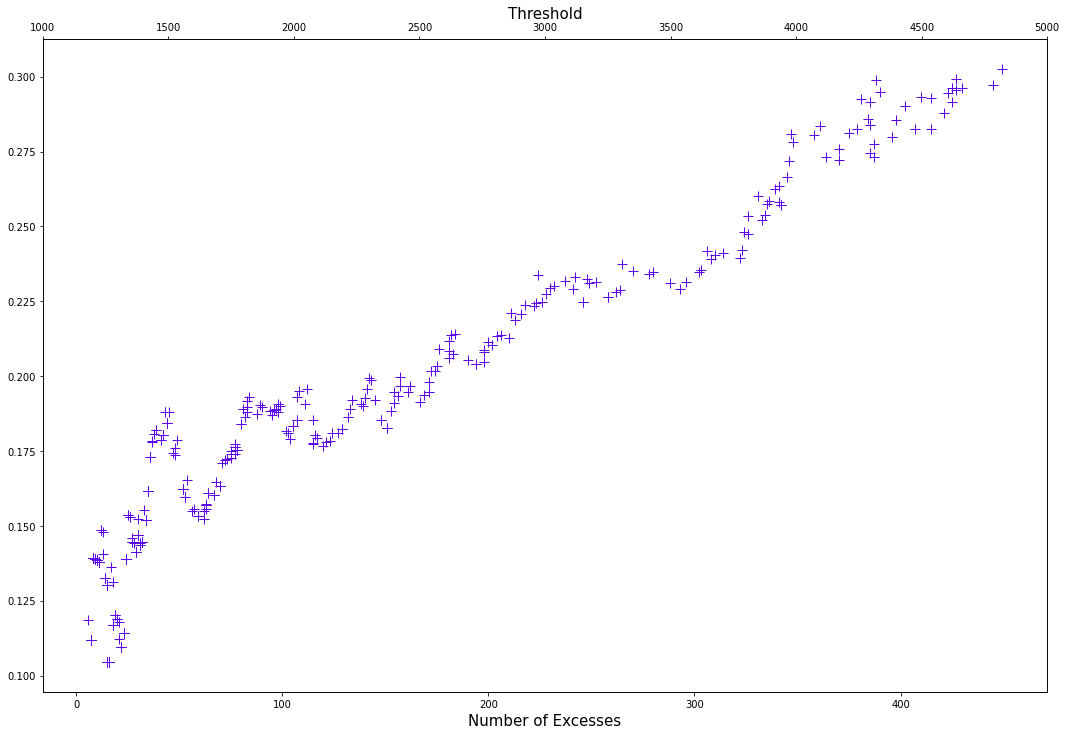

In [4]:
fig = plt.figure(figsize=(18,12))
ax1 = fig.add_subplot(111)
plt.plot(k_list, hill_estimators, "+", color=COLOR_LIST[0], ms = 10)


ax2 = ax1.twiny()
ax2.set_xbound(1000, 5000)
ax1.set_xlabel("Number of Excesses", fontsize = 15)
ax2.set_xlabel("Threshold", fontsize = 15)
plt.show()

### Mean Residual life plot

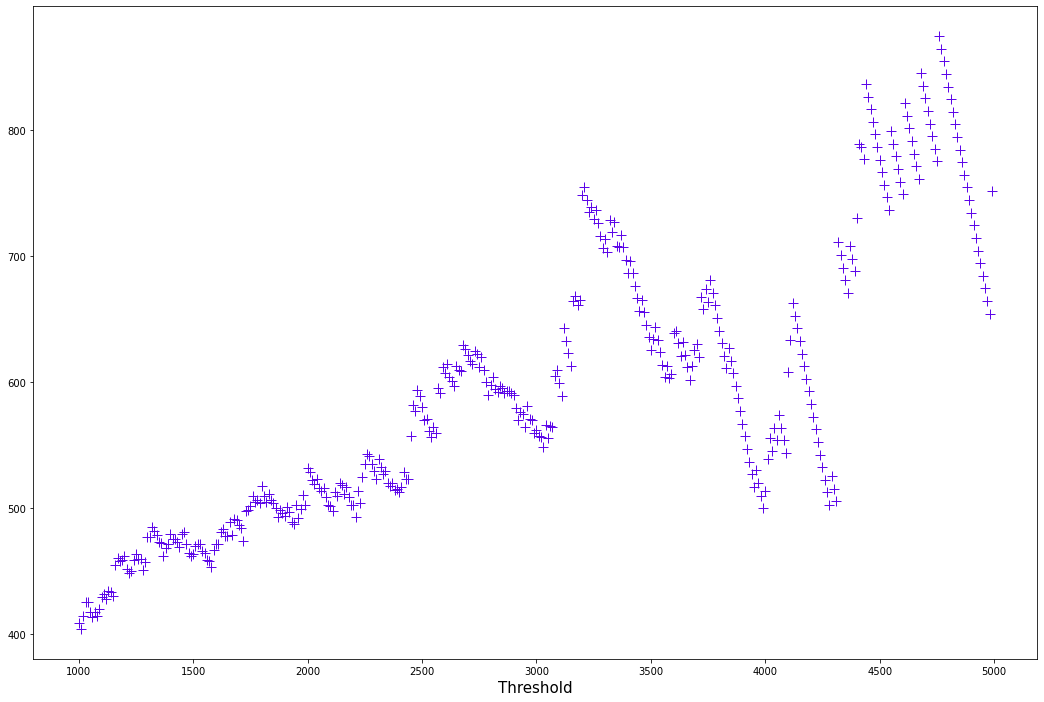

In [5]:
fig = plt.figure(figsize=(18,12))
ax1 = fig.add_subplot(111)
plt.plot(u_list, mean_residuals, "+", color=COLOR_LIST[0], ms = 10)

ax1.set_xlabel("Threshold", fontsize = 15)
plt.show()

In [6]:
threshold = 2000
decluster = True

observations_under_u, obs, time_under_u, time = extract_data_castor(threshold = threshold)

if decluster:
    obs, time = decluster_data(obs, time)

n_obs = len(obs)
n_total = len(observations_under_u)+n_obs

print("Total number of observations: {}".format(n_total))
print("Number of observations above u : {}".format(n_obs))
print("Max value : {}".format(max(obs)))

Total number of observations: 17805
Number of observations above u : 182
Max value : 5050.0


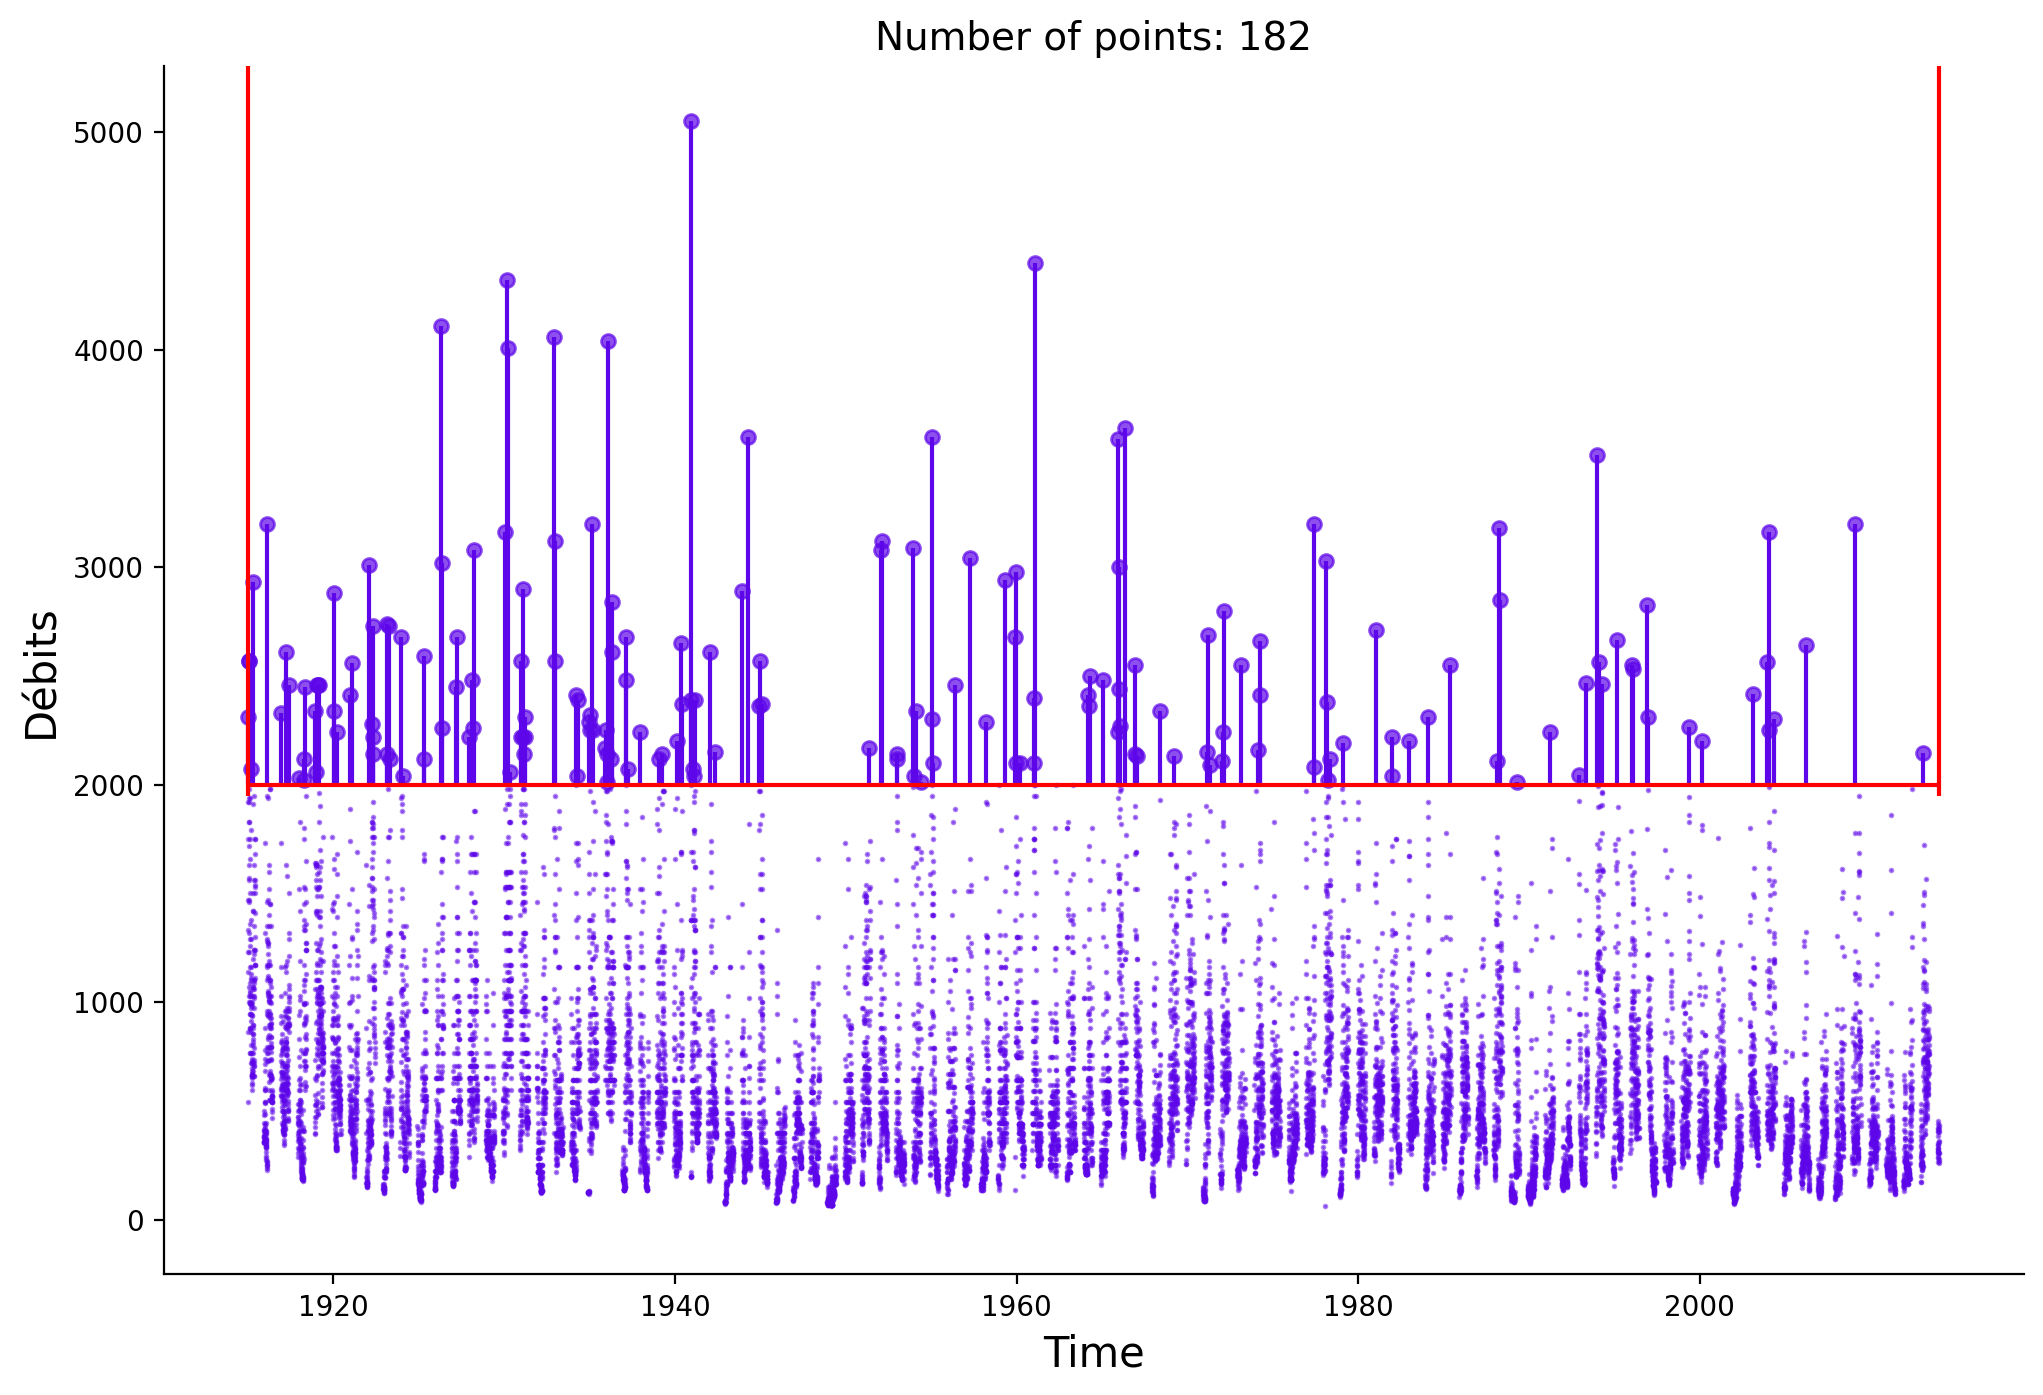

In [7]:
time_scale = range(len(observations_under_u)+n_obs)

fig = plt.figure(figsize=(12, 8), dpi=200)
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.plot(time_under_u, observations_under_u, '.', color=COLOR_LIST[0], alpha=0.5, ms=2)
ax.vlines(time, [threshold], obs, colors=COLOR_LIST[0])

ax.plot(time, obs, ".", alpha = 0.7, linewidth=1.5, ms = 10, color=COLOR_LIST[0])

ax.hlines(threshold, min(time + time_under_u), max(time + time_under_u), colors="r")
ax.vlines(min(time + time_under_u), threshold / max(obs), 1, transform=ax.get_xaxis_transform(), colors="r")
ax.vlines(max(time + time_under_u), threshold / max(obs), 1, transform=ax.get_xaxis_transform(), colors="r")

ax.set_ylabel("Débits", fontsize = 15)
ax.set_xlabel("Time", fontsize = 15)

ax.set_title("Number of points: " + str(n_obs), fontsize=14)
plt.show()

### MCMC


Config file:  Config2
Orthogonal param.
Choice of m = 30 for MCMC


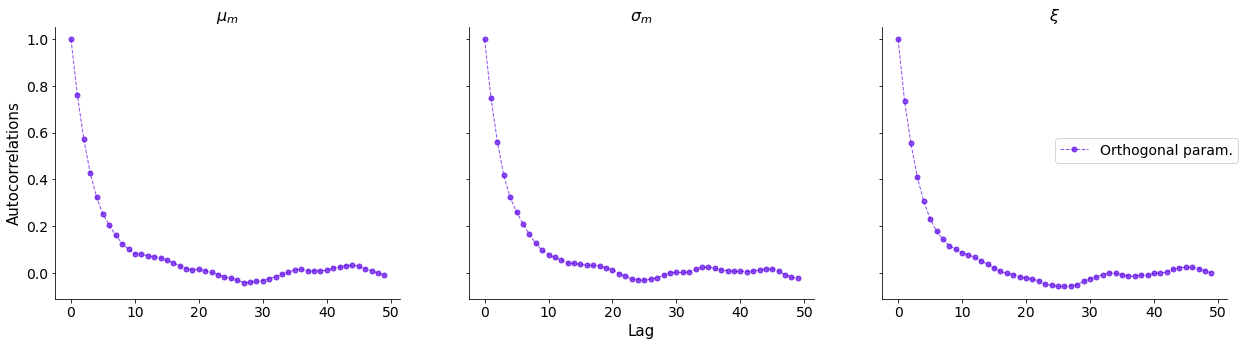

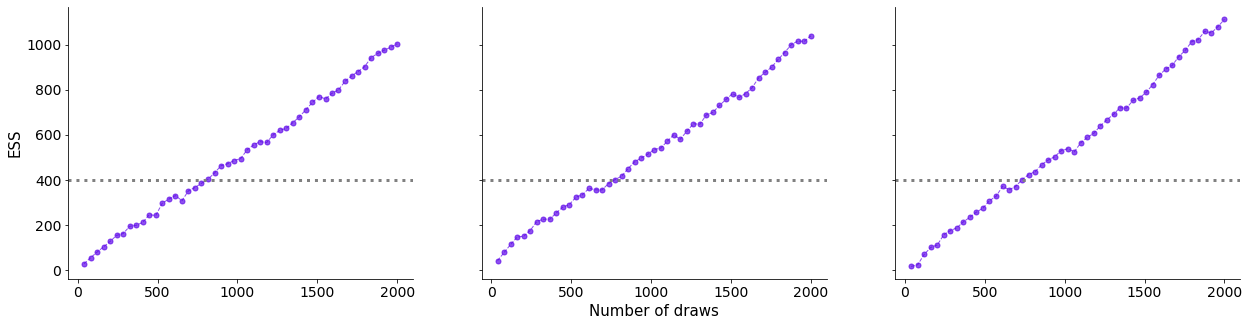

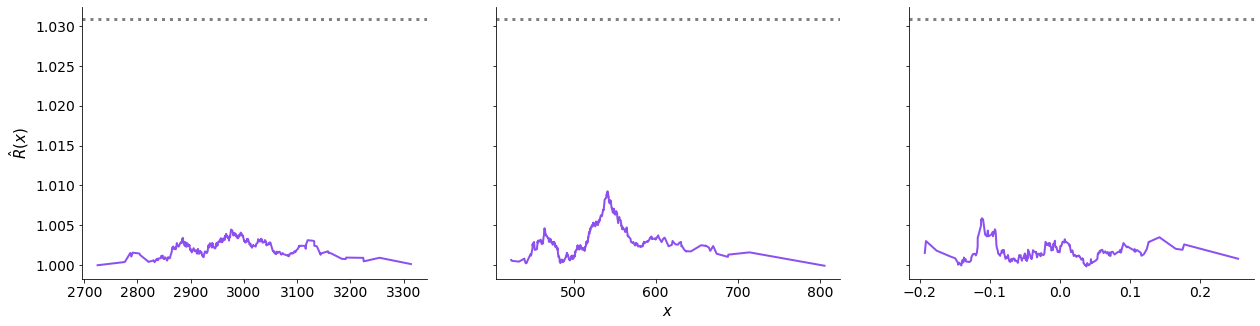

In [8]:
quantiles = (1/10000, 1/20000, 1/30000)

mcmc_params_directory = "parameters/mcmc/"
poisson_params_directory = "parameters/poisson_simu/"

mcmc_configs = ["Config2"]
poisson_config_list = ["golfech_"]


for poisson_config in poisson_config_list:
    poisson_params = Params(poisson_params_directory + poisson_config + ".json")

    # MCMC

    traces = []
    traces_orthogonal = []import warnings

#suppress warnings
warnings.filterwarnings('ignore')

    names = []
    names_orthogonal = []

    for filename in mcmc_configs:
        print("\nConfig file: ", filename)
        mcmc_params = Params(mcmc_params_directory + filename + ".json")
        print(mcmc_params.name)

        nb_dim = len(mcmc_params.priors)
        priors = [mcmc_params.priors["p1"],
                  mcmc_params.priors["p2"]]

        if nb_dim == 3:
            priors.append(mcmc_params.priors["p3"])

            if mcmc_params.init_p1_by_u:
                init_val = n_obs if mcmc_params.orthogonal_param else threshold
                priors[2] = priors[2].replace("u", str(init_val))

        MCMC = PoissonMCMC(priors=priors, step_method=mcmc_params.step_method, niter=mcmc_params.niter,
                           obs=obs, u=threshold, m=poisson_params.m, quantiles=quantiles,
                           orthogonal_param=mcmc_params.orthogonal_param)
        if mcmc_params.update_m != "":
            MCMC.update_m(update_arg=mcmc_params.update_m, xi=poisson_params.xi)
        print("Choice of m = {} for MCMC".format(MCMC.m))

        trace = MCMC.run(verbose=False)

        names.append(mcmc_params.name)
        traces.append(trace)
        
    var_names = ["mu_m", "sig_m", "xi"]            
    plot_autocorr(traces=traces, labels=names, var_names = var_names)
    plot_ess(traces=traces, labels=names, var_names = var_names)
    plot_r_hat_x(traces=traces, labels=names, var_names = var_names)


 Summary:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,mode
mu_m,2972.163,84.337,2808.490,3123.043,2.661,1.882,990.0,1217.0,1.00,2873.392
sig_m,526.547,50.420,441.409,620.908,1.564,1.106,1024.0,1107.0,1.01,452.256
xi,-0.025,0.068,-0.146,0.100,0.002,0.001,1125.0,1199.0,1.00,-0.046


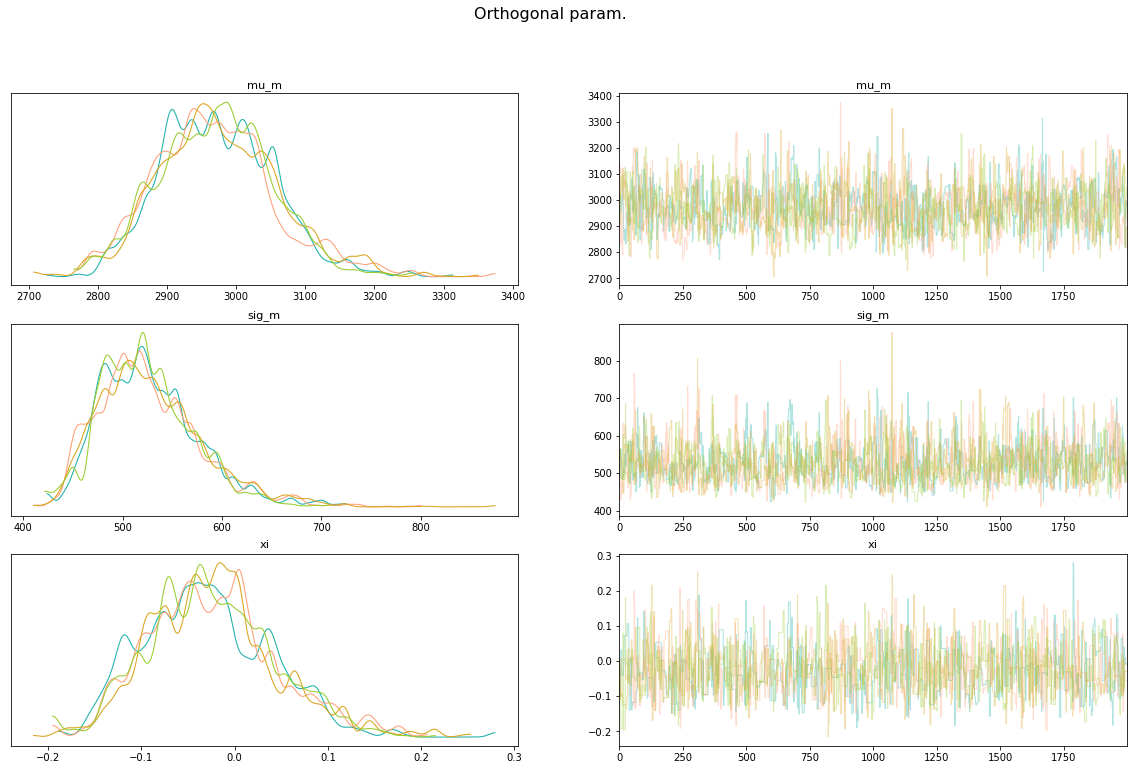

In [9]:
func_dict = {"mode": lambda x: scipy.stats.mode(x, axis=None).mode[0]}

print("\n Summary:")
display(az.summary(data=trace, stat_funcs=func_dict, var_names=["mu_m", "sig_m", "xi"]))
plot_trace(trace, var_names=["mu_m", "sig_m", "xi"], title=mcmc_params.name)
plt.show()


# print("\n Quantiles Summary:")
# display(az.summary(data=trace, stat_funcs=func_dict, var_names=["q1r", "q2r", "q3r"]))
# plot_trace(trace, var_names=["q1r", "q2r", "q3r"], title=mcmc_params.name)
# plt.show()


### Niveau de retour

In [10]:
def return_level(mu,sig,xi,yp):
    # yp = -np.log(1-1/r)
    return mu - sig/xi * (1 - yp**(-xi))

def extract_annual_maxima(time, obs):
    res = []
    idx = 0
    
    while idx < len(obs)-1:
        current_max = obs[idx]
        idx += 1
        while idx < len(obs) and time[idx].year == time[idx-1].year:
            current_max = max(current_max, obs[idx])
            idx += 1
        res.append(current_max)
    
    if time[idx].year != time[idx-1].year:
        res.append(obs[idx])
    
    return res


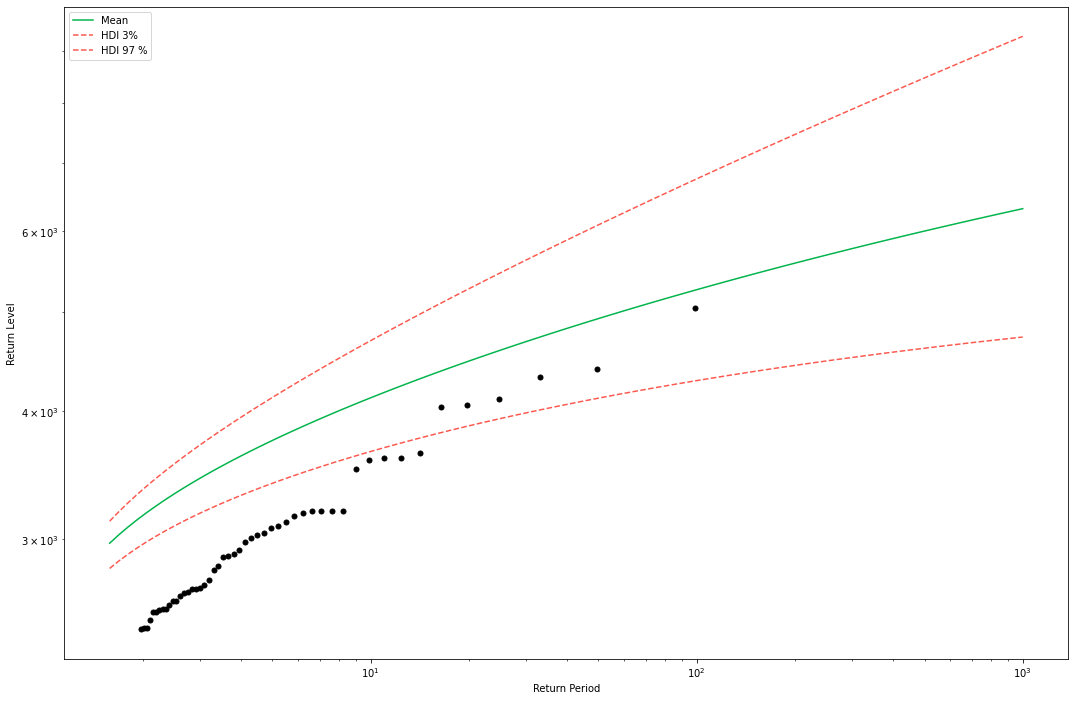

In [11]:
n_years = 99
n_data_plotted = 50

r_list = np.logspace(0.2, 3, 100)
yp_list = [-np.log(1-1/r) for r in r_list]

param_mean = az.summary(data=trace, stat_funcs=func_dict, var_names=["mu_m", "sig_m", "xi"])["mean"]
levels_mean = [return_level(param_mean["mu_m"], param_mean["sig_m"], param_mean["xi"], y) 
               for y in yp_list]

param_hdi_3 = az.summary(data=trace, stat_funcs=func_dict, var_names=["mu_m", "sig_m", "xi"])["hdi_3%"]
levels_hdi1 = [return_level(param_hdi_3["mu_m"], param_hdi_3["sig_m"], param_hdi_3["xi"], y) 
               for y in yp_list]

param_hdi_97 = az.summary(data=trace, stat_funcs=func_dict, var_names=["mu_m", "sig_m", "xi"])["hdi_97%"]
levels_hdi2 = [return_level(param_hdi_97["mu_m"], param_hdi_97["sig_m"], param_hdi_97["xi"], y) 
               for y in yp_list]



fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111)
ax.set_xscale('log')
ax.set_yscale('log')

plt.plot(r_list, levels_mean, "-", color=COLOR_LIST[1], ms = 10)
plt.plot(r_list, levels_hdi1, "--", color=COLOR_LIST[2], ms = 10)
plt.plot(r_list, levels_hdi2, "--", color=COLOR_LIST[2], ms = 10)

annual_max = np.sort(extract_annual_maxima(time, obs))[::-1]
annual_max = annual_max[:n_data_plotted]
empirical_r = [(n_years)/(i+1) for i in range(len(annual_max))]
observed_return_period = [return_level(param_mean["mu_m"], param_mean["sig_m"], param_mean["xi"],
                                       -np.log(1-(i+1)/n_years)) for i in range(len(annual_max))]
plt.plot(empirical_r, annual_max, ".", color="black", ms=10)
plt.xlabel("Return Period")
plt.ylabel("Return Level")
plt.legend(["Mean", "HDI 3%", "HDI 97 %"])
plt.show()

# Evolution de l'estimation de xi en fonction du seuil

In [22]:
threshold_list = np.linspace(1500,4500,51, dtype=int)

decluster = True

xi_means = []
xi_hdi1 = []
xi_hdi2 = []

for u in threshold_list:
    
    print("u = {}\r".format(u), end="")
    
    observations_under_u, obs, time_under_u, time = extract_data_castor(threshold = u)
    if decluster:
        obs, time = decluster_data(obs, time)
    
    # MCMC

    traces = []
    traces_orthogonal = []

    names = []
    names_orthogonal = []

    nb_dim = len(mcmc_params.priors)
    priors = [mcmc_params.priors["p1"],
              mcmc_params.priors["p2"]]

    if nb_dim == 3:
        priors.append(mcmc_params.priors["p3"])

        if mcmc_params.init_p1_by_u:
            init_val = n_obs if mcmc_params.orthogonal_param else threshold
            priors[2] = priors[2].replace("u", str(init_val))

    MCMC = PoissonMCMC(priors=priors, step_method=mcmc_params.step_method, niter=mcmc_params.niter,
                       obs=obs, u=u, m=poisson_params.m, quantiles=quantiles,
                       orthogonal_param=mcmc_params.orthogonal_param)
    if mcmc_params.update_m != "":
        MCMC.update_m(update_arg=mcmc_params.update_m, xi=poisson_params.xi)
    trace = MCMC.run(verbose=False)

    xi_means.append(az.summary(data=trace, stat_funcs=func_dict, var_names=["xi"])["mean"])
    xi_hdi1.append(az.summary(data=trace, stat_funcs=func_dict, var_names=["xi"])["hdi_3%"])
    xi_hdi2.append(az.summary(data=trace, stat_funcs=func_dict, var_names=["xi"])["hdi_97%"])

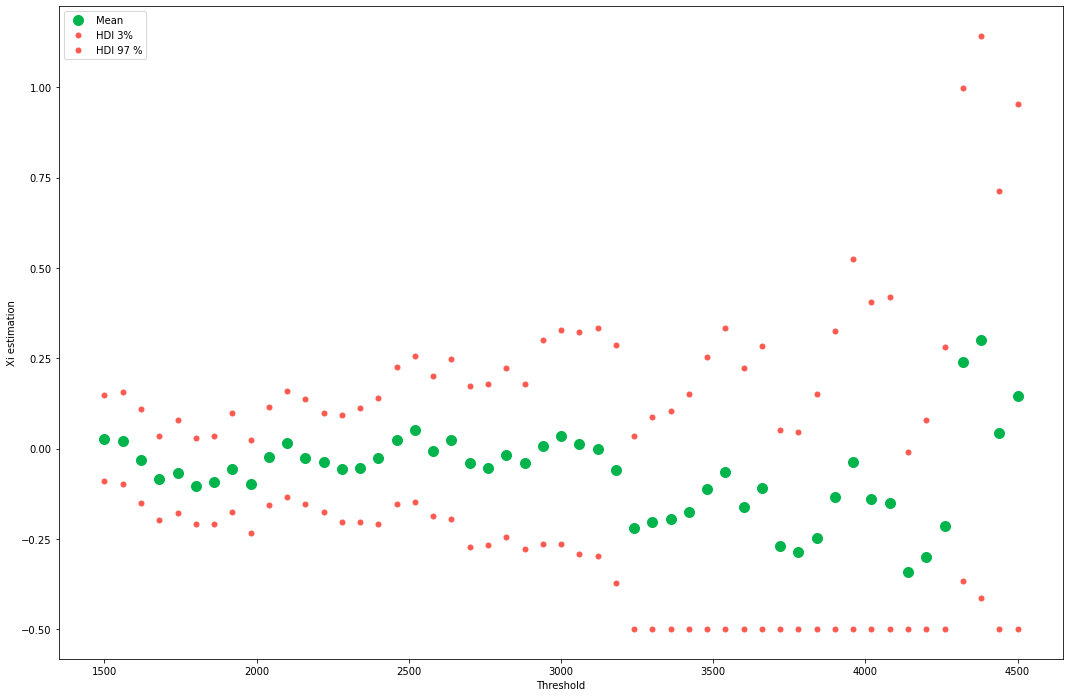

In [13]:
fig = plt.figure(figsize=(18,12))
plt.plot(threshold_list, xi_means, "o", color=COLOR_LIST[1], ms = 10)
plt.plot(threshold_list, xi_hdi1, ".", color=COLOR_LIST[2], ms = 10)
plt.plot(threshold_list, xi_hdi2, ".", color=COLOR_LIST[2], ms = 10)
plt.legend(["Mean", "HDI 3%", "HDI 97 %"])
plt.xlabel("Threshold")
plt.ylabel("Xi estimation")
plt.show()

## Comparaison avec prior Plat/Gaussien sur xi

In [18]:
# warnings.filterwarnings('ignore')

mcmc_configs = ["Config7"]
poisson_params = Params(poisson_params_directory + poisson_config + ".json")

threshold_list = np.linspace(1500,4500,51, dtype=int)

decluster = True

xi_means = []
xi_hdi1 = []
xi_hdi2 = []

for u in threshold_list:
    
    print("u = {}\r".format(u), end="")
    
    observations_under_u, obs, time_under_u, time = extract_data_castor(threshold = u)
    if decluster:
        obs, time = decluster_data(obs, time)
    
    # MCMC

    traces = []
    traces_orthogonal = []

    names = []
    names_orthogonal = []

    nb_dim = len(mcmc_params.priors)
    priors = [mcmc_params.priors["p1"],
              mcmc_params.priors["p2"]]

    if nb_dim == 3:
        priors.append(mcmc_params.priors["p3"])

        if mcmc_params.init_p1_by_u:
            init_val = n_obs if mcmc_params.orthogonal_param else threshold
            priors[2] = priors[2].replace("u", str(init_val))

    MCMC = PoissonMCMC(priors=priors, step_method=mcmc_params.step_method, niter=mcmc_params.niter,
                       obs=obs, u=u, m=poisson_params.m, quantiles=quantiles,
                       orthogonal_param=mcmc_params.orthogonal_param)
    if mcmc_params.update_m != "":
        MCMC.update_m(update_arg=mcmc_params.update_m, xi=poisson_params.xi)
    trace = MCMC.run(verbose=False)

    xi_means.append(az.summary(data=trace, stat_funcs=func_dict, var_names=["xi"])["mean"])
    xi_hdi1.append(az.summary(data=trace, stat_funcs=func_dict, var_names=["xi"])["hdi_3%"])
    xi_hdi2.append(az.summary(data=trace, stat_funcs=func_dict, var_names=["xi"])["hdi_97%"])

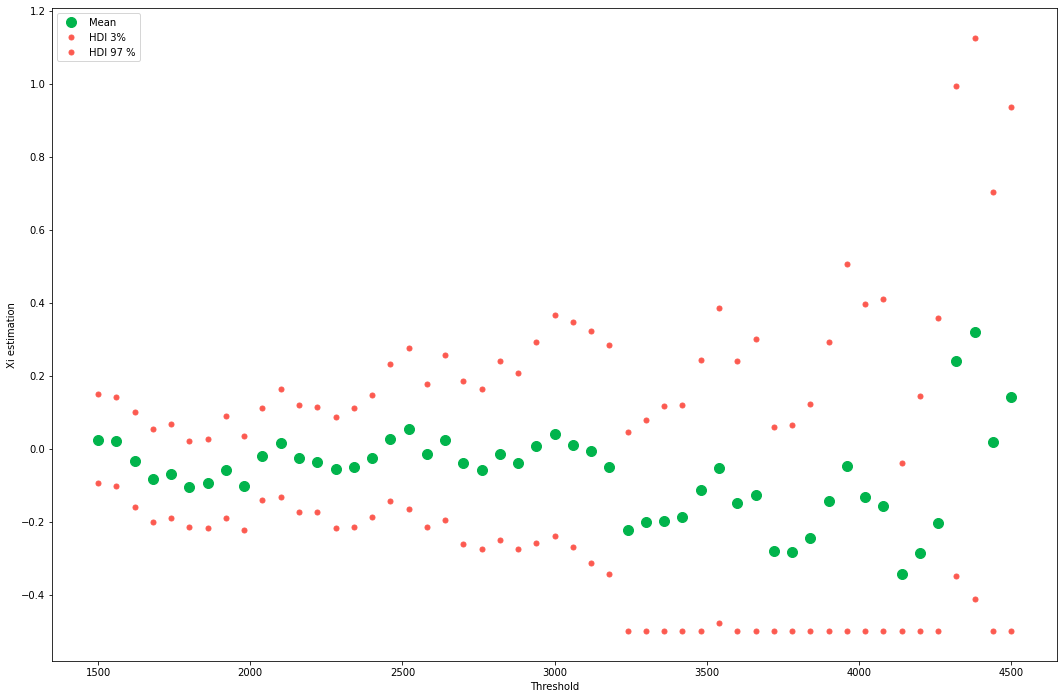

In [19]:
fig = plt.figure(figsize=(18,12))
plt.plot(threshold_list, xi_means, "o", color=COLOR_LIST[1], ms = 10)
plt.plot(threshold_list, xi_hdi1, ".", color=COLOR_LIST[2], ms = 10)
plt.plot(threshold_list, xi_hdi2, ".", color=COLOR_LIST[2], ms = 10)
plt.legend(["Mean", "HDI 3%", "HDI 97 %"])
plt.xlabel("Threshold")
plt.ylabel("Xi estimation")
plt.show()